PUNTO N°0: IMPORT DI BASE

In [ ]:
# NumPy per calcolo numerico e gestione di array/matrici
import numpy as np

# Pandas per tabelle (DataFrame): caricamento CSV, pulizia, join, ecc
import pandas as pd

# Matplotlib per grafici (linee, istogrammi, scatter, ecc.)
import matplotlib.pyplot as plt

# Seaborn: grafici “più belli” e veloci sopra Matplotlib (heatmap, countplot…)
import seaborn as sns

# STRUMENTI DI MODEL SELECTION
# train_test_split: crea i set train/test
# StratifiedKFold: k-fold che mantiene la proporzione delle classi (utile con churn sbilanciato)
# RandomizedSearchCV: ricerca casuale di iperparametri con cross-validation (più veloce di grid)
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# TRASFORMAZIONI PER COLONNE
# Applica pipeline diverse a insiemi di colonne (es. numeriche vs categoriche)
from sklearn.compose import ColumnTransformer

# PREPROCESSING
# OneHotEncoder: converte categoriche in dummy/one-hot
# StandardScaler: standardizza numeriche (media 0, dev std 1)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Gestisce valori mancanti (es. mediane per numeriche, moda per categoriche)
from sklearn.impute import SimpleImputer

# PIPELINE
# Concatena fasi (preprocessing → modello) in un unico oggetto: ordine fisso, niente leakage, comodo da salvare
from sklearn.pipeline import Pipeline

# METRICHE E CURVE
# accuracy_score: (TP+TN)/totale — ok solo se classi bilanciate
# precision_score: fra i predetti positivi, quanti sono corretti
# recall_score: fra i veri positivi, quanti li prendi (sensibilità)
# f1_score: media armonica tra precision e recall
# roc_auc_score: area sotto ROC; misura separabilità globale
# confusion_matrix: TP/TN/FP/FN
# classification_report: precision/recall/F1 per classe, macro/weighted
# roc_curve: coordinate per tracciare la curva ROC
# precision_recall_curve: coordinate per la PR curve (molto utile con classi sbilanciate)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)

# MODELLI
# Logistic Regression: baseline interpretabile per classificazione binaria
from sklearn.linear_model import LogisticRegression
# Random Forest: insieme di alberi, robusto su dati tabellari, cattura non linearità e interazioni
from sklearn.ensemble import RandomForestClassifier

# SEMINA DEL GENERATORE CAUSALE
# Numero fisso per la riproducibilità
RNG_SEED = 42
# Imposta il seed di NumPy
np.random.seed(RNG_SEED)


PUNTO N°1: # IMPORT E COSTANTI

In [ ]:
# os per operazioni su file/cartelle
# zipfile per leggere/estrarre .zip
# pathlib per path “a oggetti” (più comodo/portabile di stringhe),
# pandas per leggere il CSV in un DataFrame
import os
import zipfile
import pathlib
import pandas as pd

# Nome atteso dello zip scaricato da Kaggle
ZIP_NAME  = "archive.zip"

# Cartella dove vogliamo tenere i dati estratti.
DATA_DIR  = pathlib.Path("data")

# Percorso finale “canonico” del CSV
DEST_CSV  = DATA_DIR / "telco.csv"

# Mostra la current working directory ( utile per capire dove sta girando il notebook )
print("CWD:", os.getcwd())

# Crea ./data se non esiste (idempotente: non dà errore se già c’è)
DATA_DIR.mkdir(exist_ok=True)

# FUNZIONE DI UTILITA' (SCEGLIERE IL FILE GIUSTO)
# Helper che, tra una lista di nomi (Path o stringhe), sceglie il CSV più plausibile
def _pick_preferred(names):
    # loop con enumerate per trovare il primo che contiene "telco" o "churn", se non trova nulla, ritorna il primo della lista
    low = [str(n).lower() for n in names]
    for i, s in enumerate(low):
        if "telco" in s or "churn" in s:
            return names[i]
    return names[0]

# SE TELCO.CSV NON ESISTE ALLORA:
# Se il file finale esiste già, saltiamo tutta la parte di estrazione/rename e lo leggiamo soltanto
if not DEST_CSV.exists():
    
    # Cerca ricorsivamente CSV già presenti in data/
    existing_csvs = list(DATA_DIR.rglob("*.csv"))
    
    # C'E' GIA' UN CSV IN DATA:
    if existing_csvs:
        
        # Sceglie il CSV migliore (telco/churn se c’è)
        src = _pick_preferred(existing_csvs)
        # Messaggio informativo
        print("CSV già presente, rinomino ->", DEST_CSV)
        # Assicuriamo che sia un Path
        src = pathlib.Path(src)
        # Ae è lo stesso file, non fare nulla; altrimenti rinomina/sposta
        if src.resolve() != DEST_CSV.resolve():
            DEST_CSV.parent.mkdir(parents=True, exist_ok=True)
            src.rename(DEST_CSV)
    
    # SE NON C'E' NESSUN CSV (ESTRAI DALLO ZIP)
    else:
        
        # Ae non c’è la zip accanto al notebook, ferma con un messaggio chiaro
        assert pathlib.Path(ZIP_NAME).exists(), f"Non trovo {ZIP_NAME} nella stessa cartella del notebook."
        # Apre la zip
        with zipfile.ZipFile(ZIP_NAME) as z:
            
            # Lista dei file CSV contenuti nella zip
            names = [n for n in z.namelist() if n.lower().endswith(".csv")]
            # Se lo zip non contiene CSV, ferma con messaggio chiaro
            assert names, "Nessun CSV trovato dentro allo zip."
            # Sceglie il CSV più plausibile da estrarre
            to_extract = _pick_preferred(names)
            print("Estraggo dal .zip:", to_extract)
            # Estrae quel file dentro data/
            z.extract(to_extract, DATA_DIR)
            # Percorso atteso del file appena estratto
            extracted = DATA_DIR / to_extract
            # Se lo zip contiene sottocartelle, trova il file estratto e rinominalo
            if not extracted.exists():
                extracted = next(DATA_DIR.rglob(os.path.basename(to_extract)))
            extracted.rename(DEST_CSV)

# LETTURA E CHECK VELOCI
print("Leggo:", DEST_CSV)
df = pd.read_csv(DEST_CSV)

print("Shape (righe, colonne):", df.shape)
print("Prime colonne:", df.columns.tolist()[:10], "...")
assert "Churn" in df.columns, "Manca la colonna target 'Churn'!"

df.head()


CWD: /Users/alessandrodonca/Library/Mobile Documents/com~apple~CloudDocs/H-Farm/2_YEAR/LISE
Leggo: data/telco.csv
Shape (righe, colonne): (7043, 21)
Prime colonne: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity'] ...


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# VERSIONE PIU' CORTA

import pandas as pd, zipfile, pathlib

ZIP = "archive.zip"
with zipfile.ZipFile(ZIP) as z:
    # sceglie il CSV "più probabile" (contiene telco/churn), altrimenti il primo
    names = [n for n in z.namelist() if n.lower().endswith(".csv")]
    csv_name = sorted(names, key=lambda s: ("telco" not in s.lower(), "churn" not in s.lower(), len(s)))[0]
    df = pd.read_csv(z.open(csv_name))

print("Shape:", df.shape)
df.head()


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


PUNTO N°2: PULIZIA MINIMA E SANITY CHECK

In [ ]:
# Pulizia stringhe
# Seleziona tutte le colonne di tipo stringa (object)
for c in df.select_dtypes(include='object').columns:
    # astype assicura che la colonna sia trattata come testo
    # elimina spazi bianchi all’inizio e alla fine
    df[c] = df[c].astype(str).str.strip()

# Conversione TotalCharges a numerico
if 'TotalCharges' in df.columns:
    # pd.to_numeric(df['TotalCharges'],errors='coerce') se trova un valore non numerico lo converte in NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Controllo del missing value (top 10)
# df.isna().sum() conta i NaN per colonna
# sort_values(ascending=False) ordina dalla colonna con più NaN a quella con meno
# head(10) mostra le prime 10
missing = df.isna().sum().sort_values(ascending=False)
print("Missing (prime 10 colonne con NaN):")
print(missing[missing > 0].head(10), "\n")

# Distribuzione del target (churn rate)
# value_counts(normalize=True) calcola le proporzioni di No/Yes (non i conteggi assoluti)
# rename('class_share') mette un’etichetta alla Serie
churn_share = df['Churn'].value_counts(normalize=True).rename('class_share')
print("Churn share:", churn_share.round(3).to_dict())


Missing (prime 10 colonne con NaN):
TotalCharges    11
dtype: int64 

Churn share: {'No': 0.735, 'Yes': 0.265}


PUNTO N°3: EDA RAPIDA

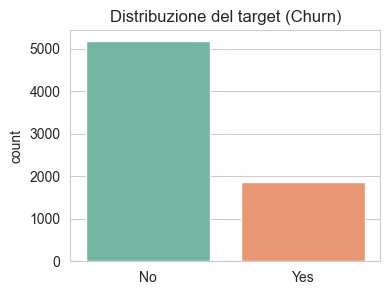

Numeriche: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categoriche (prime 10): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'] ...


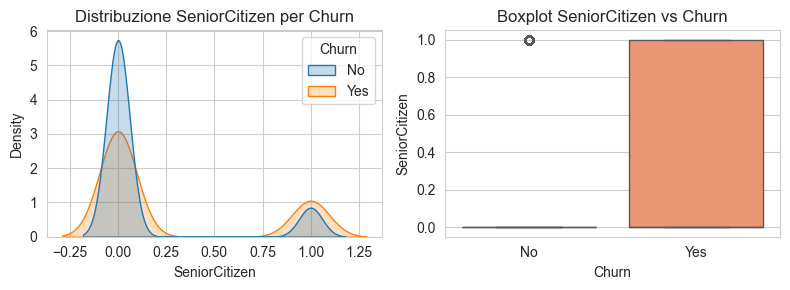

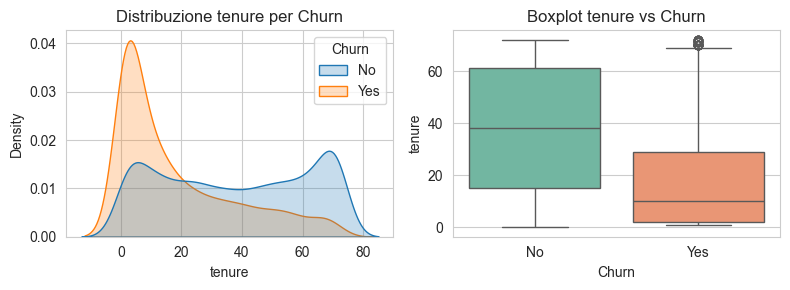

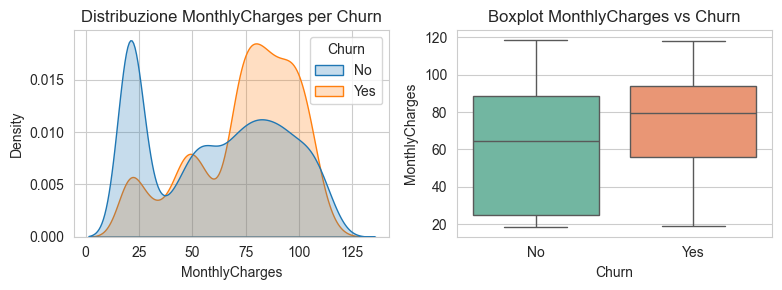

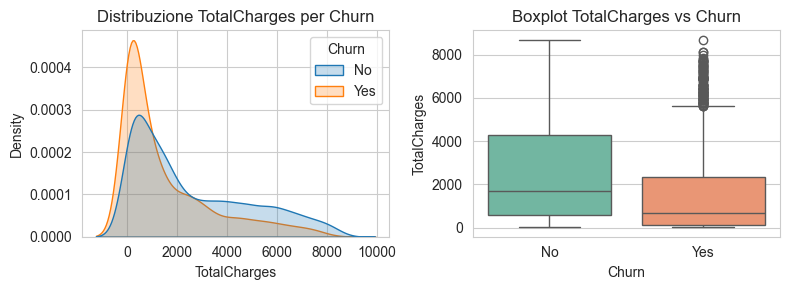

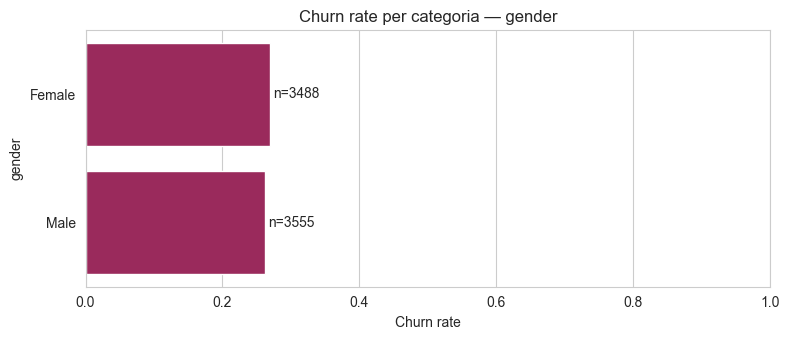

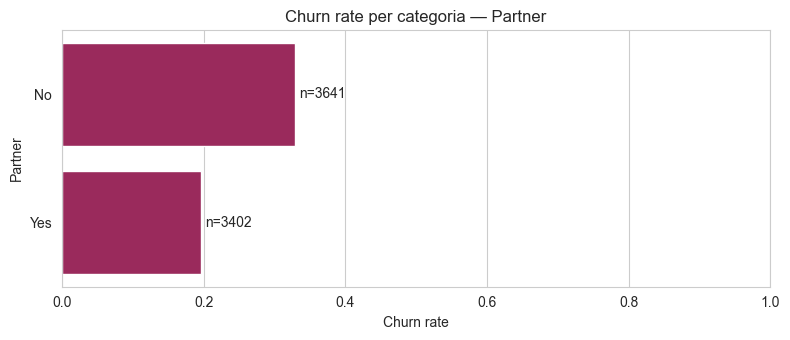

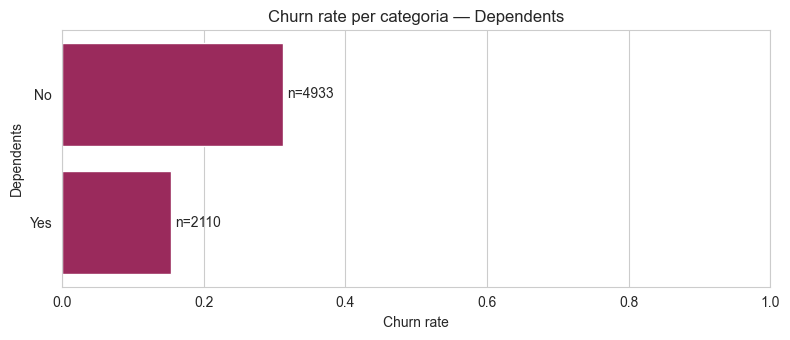

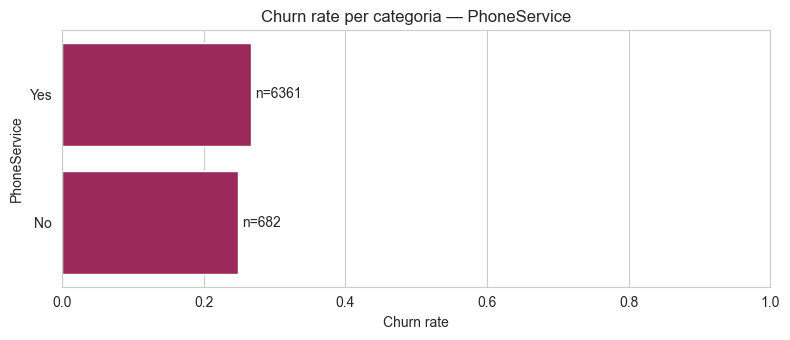

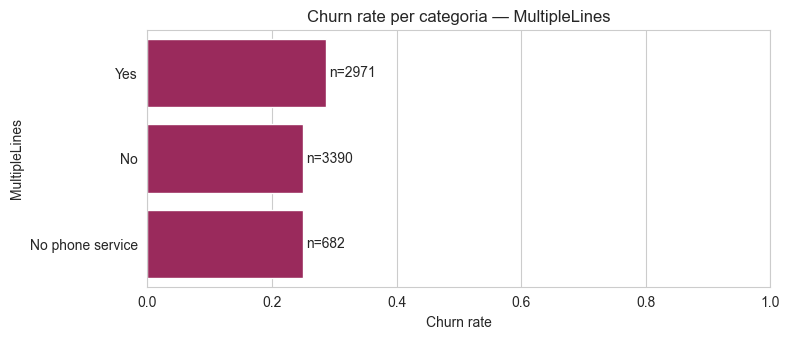

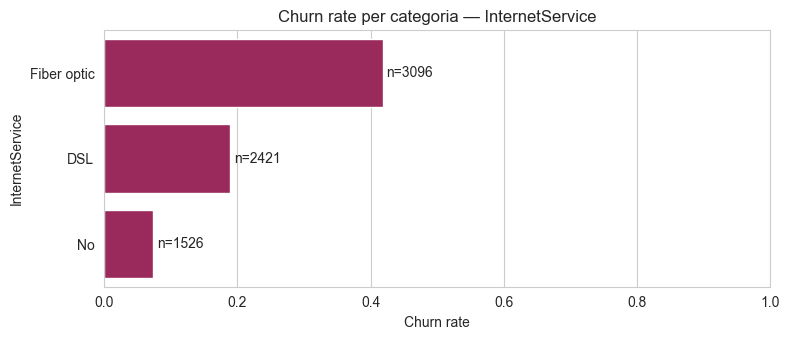

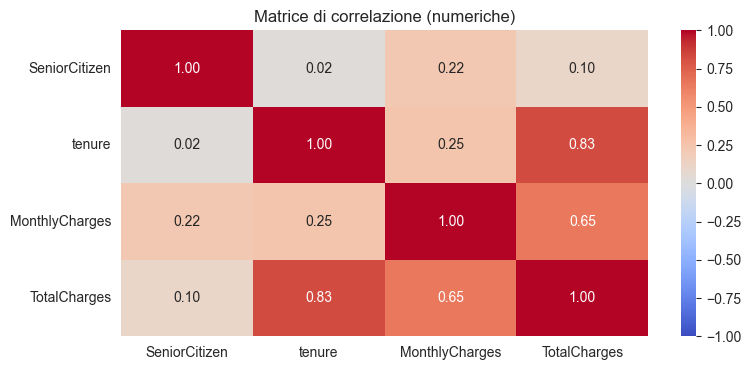

Churn share: {'No': 0.735, 'Yes': 0.265}


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style("whitegrid")

# Target binario d'appoggio (serve per calcoli e grafici)
y_bin = df['Churn'].map({'Yes': 1, 'No': 0})

# Distribuzione del target
plt.figure(figsize=(4,3))
sns.countplot(data=df, x='Churn', hue='Churn', palette='Set2', legend=False)
plt.title('Distribuzione del target (Churn)')
plt.xlabel('')
plt.show()

# Colonne numeriche / categoriche
num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols + ['customerID', 'Churn']]

print("Numeriche:", num_cols)
print("Categoriche (prime 10):", cat_cols[:10], "...")

# Numeric vs Churn: KDE + Boxplot (per ognuna delle numeriche principali)
# Loop su ogni colonna numerica
# Crea 2 sottografici affiancati
# A sinistra: KDE (curve di densità) di c separate per Churn; common_norm=False evita normalizzazioni “strane” tra classi; fill=True riempie l’area
# A destra: boxplot di c condizionato a Churn (mediana, quartili, outlier)
# Tight_layout() compatta gli spazi.
for c in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    sns.kdeplot(data=df, x=c, hue='Churn', common_norm=False, fill=True, ax=axes[0])
    axes[0].set_title(f'Distribuzione {c} per Churn')
    sns.boxplot(data=df, x='Churn', y=c, hue='Churn',
            palette='Set2', dodge=False, legend=False, ax=axes[1])
    axes[1].set_title(f'Boxplot {c} vs Churn')
    plt.tight_layout()
    plt.show()

# Churn rate per categoria (grafico a barre) — limitiamo a 6 per non fare troppi grafici
# Definisce una funzione per una colonna categorica col:
# Groupby(col)['Churn'].apply(lambda s: (s=='Yes').mean()) → per ogni categoria calcola la percentuale di Yes (churn rate ∈ [0,1])
# Cnt è la numerosità per categoria (per annotare n=)
# Ordina le categorie dal churn rate dal più alto al più basso
# Disegna un barplot orizzontale con annotazioni di n
# Forza l’asse X a [0,1] per interpretare subito come percentuale
def plot_churn_rate(col, topn=15):
    rate = df.groupby(col)['Churn'].apply(lambda s: (s=='Yes').mean())
    cnt  = df[col].value_counts()
    order = rate.sort_values(ascending=False).index
    plt.figure(figsize=(8,3.5))
    sns.barplot(x=rate.loc[order].values, y=order,
            color=sns.color_palette('rocket')[2])

    plt.xlabel('Churn rate')
    plt.ylabel(col)
    # annotazioni con la numerosità
    for i, k in enumerate(order):
        plt.text(rate.loc[k]+0.005, i, f"n={cnt[k]}", va='center')
    plt.xlim(0, 1)
    plt.title(f'Churn rate per categoria — {col}')
    plt.tight_layout()
    plt.show()

for c in cat_cols[:6]:
    plot_churn_rate(c)

# Correlazioni tra numeriche
# Se ci sono almeno 2 numeriche, calcola la matrice di correlazione
# Numeric_only=True evita warning se per caso entra una colonna non numerica
# Heatmap con annotazioni a 2 decimali; palette blu-rosso; limiti -1..1.
if len(num_cols) >= 2:
    plt.figure(figsize=(4+len(num_cols), 3+len(num_cols)*0.2))
    corr = df[num_cols].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Matrice di correlazione (numeriche)')
    plt.tight_layout()
    plt.show()

# Churn rate globale (comodo da stampare)
churn_share = df['Churn'].value_counts(normalize=True).rename('class_share')
print("Churn share:", churn_share.round(3).to_dict())


PUNTO N°4: X/Y E SPLIT STRATIFICATO

In [ ]:
# Rimuovo ID non informativo (se presente)
drop_cols = [c for c in ['customerID'] if c in df.columns]
df = df.drop(columns=drop_cols)

# Target binario y e feature X
y = df['Churn'].map({'Yes': 1, 'No': 0})
X = df.drop(columns=['Churn'])

# Liste delle colonne numeriche e categoriche ( serviranno per il pre process )
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

print("Numeriche:", num_features)
print("Categoriche:", cat_features)

# Train/Test split stratificato ( mantiene il rapporto Yes/No )
from sklearn.model_selection import train_test_split
RNG_SEED = 42  # ( se già definito sopra, va bene lasciarlo )
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RNG_SEED
)

print(f"Train: {X_train.shape}  |  Test: {X_test.shape}")
print("Churn rate Train/Test:", round(y_train.mean(), 3), "/", round(y_test.mean(), 3))


Numeriche: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categoriche: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Train: (5634, 19)  |  Test: (1409, 19)
Churn rate Train/Test: 0.265 / 0.265


PUNTO N°5: PREPROCESS (IMPUTER+SCALER PER NUMERICHE, IMPUTER+ONE-HOT PER CATEGORIE)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

# 5.1 Trasformazioni per le colonne NUMERICHE:
#     - Imputazione dei NaN con la mediana
#     - Standardizzazione (media=0, std=1)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# 5.2 Trasformazioni per le colonne CATEGORICHE:
#     - Imputazione dei NaN con la moda (valore più frequente)
#     - One-Hot Encoding (ignora categorie mai viste nel train)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 5.3 ColumnTransformer: applica i due rami ai rispettivi insiemi di colonne
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# 5.4 (Facoltativo ma utile) Fit sul SOLO train per verificare la shape dopo il preprocess
preprocess.fit(X_train)

# 5.5 Controllo shape delle matrici trasformate (dopo imputazione/scaling/one-hot)
X_train_t = preprocess.transform(X_train)
X_test_t  = preprocess.transform(X_test)
print("Shape dopo preprocess — train:", X_train_t.shape, " | test:", X_test_t.shape)

# 5.6 (Facoltativo) Nomi delle feature dopo l’encoding: utile per interpretare modelli lineari / feature importance
feat_names = preprocess.get_feature_names_out()
print("Prime 15 feature:", feat_names[:15])


Shape dopo preprocess — train: (5634, 45)  | test: (1409, 45)
Prime 15 feature: ['num__SeniorCitizen' 'num__tenure' 'num__MonthlyCharges'
 'num__TotalCharges' 'cat__gender_Female' 'cat__gender_Male'
 'cat__Partner_No' 'cat__Partner_Yes' 'cat__Dependents_No'
 'cat__Dependents_Yes' 'cat__PhoneService_No' 'cat__PhoneService_Yes'
 'cat__MultipleLines_No' 'cat__MultipleLines_No phone service'
 'cat__MultipleLines_Yes']


PUNTO N°6: BASELINE 1 LOGISTIC REGRESSION

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

# 6.1 Definisco una pipeline: PREPROCESS (punto 5) + CLASSIFICATORE LOGISTICO
logreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(
        max_iter=500,            # più iterazioni per garantire la convergenza
        class_weight='balanced', # compensa classi sbilanciate (Yes/No)
        random_state=RNG_SEED    # riproducibilità
    ))
])

# 6.2 Addestro il modello sul TRAIN
logreg.fit(X_train, y_train)

# 6.3 Sanity check rapido sul TEST (valutazione completa al Punto 7)
proba_test = logreg.predict_proba(X_test)[:, 1]      # probabilità della classe "Yes"
pred_test  = (proba_test >= 0.5).astype(int)         # soglia 0.5 per etichette
acc  = accuracy_score(y_test, pred_test)             # accuratezza grezza
roc  = roc_auc_score(y_test, proba_test)             # ROC-AUC (più informativa)
print(f"Baseline LogReg — Accuracy: {acc:.3f} | ROC-AUC: {roc:.3f}")


Baseline LogReg — Accuracy: 0.738 | ROC-AUC: 0.841


PUNTO N°7: VALUTAZIONE COMPLETA + ROC/PR + SOGLIA OTTIMALE F1

[LogReg baseline] Acc=0.738  Prec=0.504  Rec=0.783  F1=0.614  ROC-AUC=0.841
              precision    recall  f1-score   support

           0      0.902     0.722     0.802      1035
           1      0.504     0.783     0.614       374

    accuracy                          0.738      1409
   macro avg      0.703     0.753     0.708      1409
weighted avg      0.797     0.738     0.752      1409



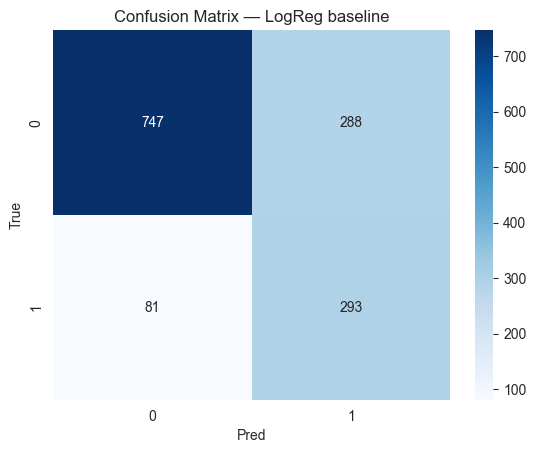

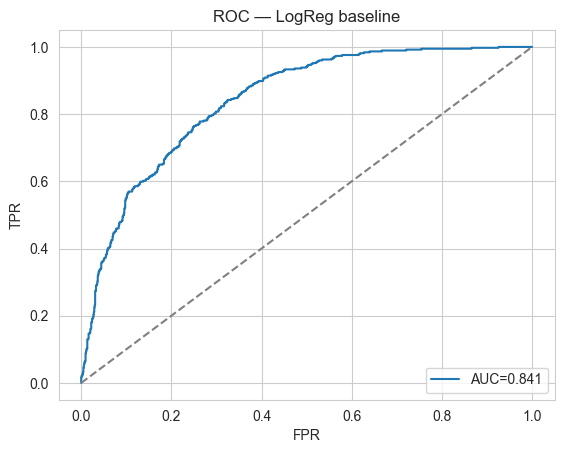

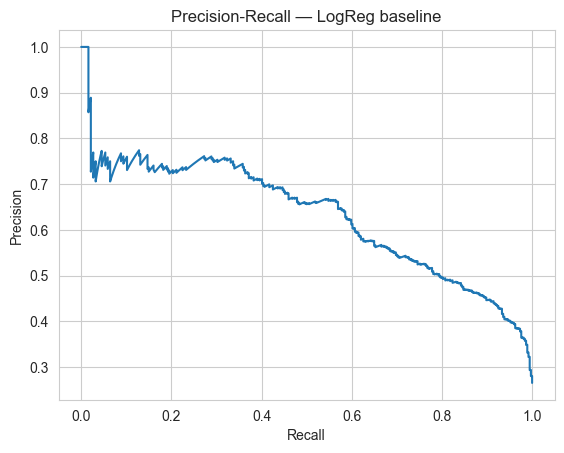

Soglia migliore (max F1): 0.542  |  F1=0.622


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

def evaluate(model, X, y, title=''):
    # 7.1 Probabilità di classe positiva ("Yes")
    proba = model.predict_proba(X)[:, 1]
    # 7.2 Predizione etichetta con soglia 0.5 (baseline)
    preds = (proba >= 0.5).astype(int)

    # 7.3 Metriche principali
    acc = accuracy_score(y, preds)
    pre = precision_score(y, preds)
    rec = recall_score(y, preds)
    f1  = f1_score(y, preds)
    roc = roc_auc_score(y, proba)
    print(f'[{title}] Acc={acc:.3f}  Prec={pre:.3f}  Rec={rec:.3f}  F1={f1:.3f}  ROC-AUC={roc:.3f}')
    print(classification_report(y, preds, digits=3))

    # 7.4 Confusion matrix
    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {title}')
    plt.xlabel('Pred'); plt.ylabel('True')
    plt.show()

    # 7.5 Curva ROC
    fpr, tpr, _ = roc_curve(y, proba)
    plt.plot(fpr, tpr, label=f'AUC={roc:.3f}')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.legend(loc='lower right')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC — {title}')
    plt.show()

    # 7.6 Curva Precision-Recall
    prec, recs, thr = precision_recall_curve(y, proba)
    plt.plot(recs, prec)
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'Precision-Recall — {title}')
    plt.show()

    # 7.7 Soglia che massimizza F1 (scansione su tutte le soglie possibili)
    if len(thr):
        # Nota: 'thr' ha len = len(prec)-1; estendo con 1.0 per coprire tutta la griglia
        thrs = np.r_[thr, 1.0]
        f1s = [(f1_score(y, (proba >= t).astype(int))) for t in thrs]
        i = int(np.argmax(f1s))
        print(f"Soglia migliore (max F1): {thrs[i]:.3f}  |  F1={f1s[i]:.3f}")
    else:
        print("Nessuna soglia alternativa disponibile.")

# 7.8 Esecuzione valutazione per il modello baseline (LogReg dal punto 6)
evaluate(logreg, X_test, y_test, title='LogReg baseline')


PUNTO N°8: BASELINE 2 RANDOM FOREST

[RandomForest baseline] Acc=0.782  Prec=0.616  Rec=0.476  F1=0.537  ROC-AUC=0.821
              precision    recall  f1-score   support

           0      0.825     0.893     0.858      1035
           1      0.616     0.476     0.537       374

    accuracy                          0.782      1409
   macro avg      0.720     0.684     0.697      1409
weighted avg      0.770     0.782     0.772      1409



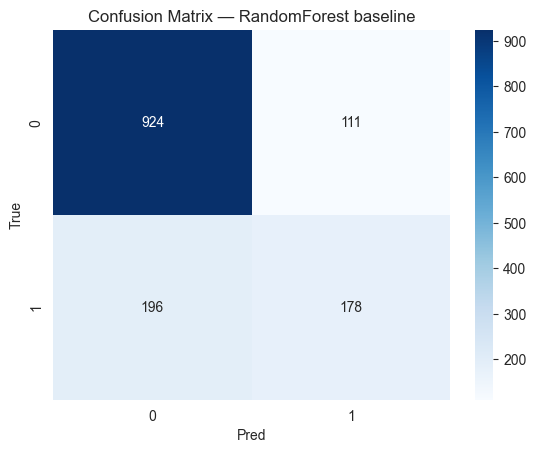

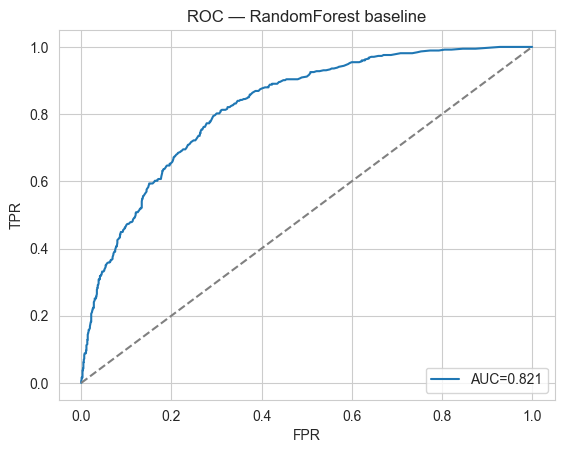

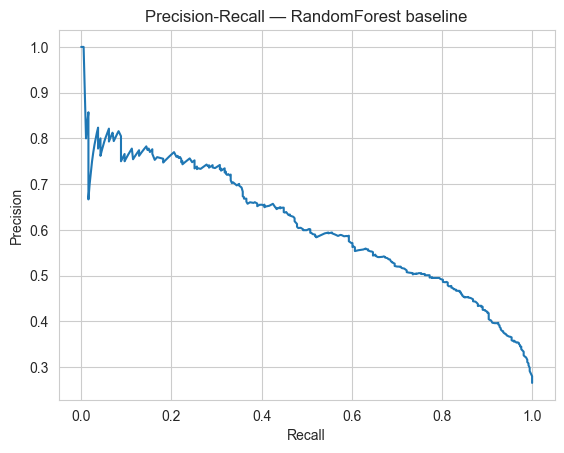

Soglia migliore (max F1): 0.242  |  F1=0.610


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# 8.1 Definisco la pipeline: PREPROCESS (imputer+OHE) + RANDOM FOREST
rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=400,              # numero alberi (più alto = più stabile, ma più lento)
        max_depth=None,                # profondità libera (lasciamo crescere e regoliamo con min_samples_*)
        min_samples_split=2,           # split minimo per nodo
        min_samples_leaf=1,            # foglia minima
        max_features='sqrt',           # feature considerate per split (buon default)
        class_weight='balanced_subsample',  # compensa lo sbilanciamento a livello di bootstrap
        n_jobs=-1,                     # usa tutti i core disponibili
        random_state=RNG_SEED          # riproducibilità
    ))
])

# 8.2 Addestro sul TRAIN
rf.fit(X_train, y_train)

# 8.3 Valutazione completa sul TEST (riuso la funzione 'evaluate' del punto 7)
evaluate(rf, X_test, y_test, title='RandomForest baseline')


PUNTO N°9: HYPERPARAMETER TUNING - RANDOM FOREST CON RANDOMIZEDSEARCHCV

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 100
max_resources_: 800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 100
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 3
n_resources: 300
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'clf__min_samples_split': 2, 'clf__min_samples_leaf': 8, 'clf__max_features': 'log2', 'clf__max_depth': 10, 'clf__n_estimators': 300}
[RF tuned (halving)] Acc=0.762  Prec=0.536  Rec=0.778  F1=0.635  ROC-AUC=0.843
              precision    recall  f1-score   support

           0      0.904     0.757     0.824      1035
           1      0.536     0.778     0.635       374

    accuracy                          0.762      1409
   macro avg      0.720     0.767     0.729      1409
weighted avg      0.806     0.762     0.774      1409



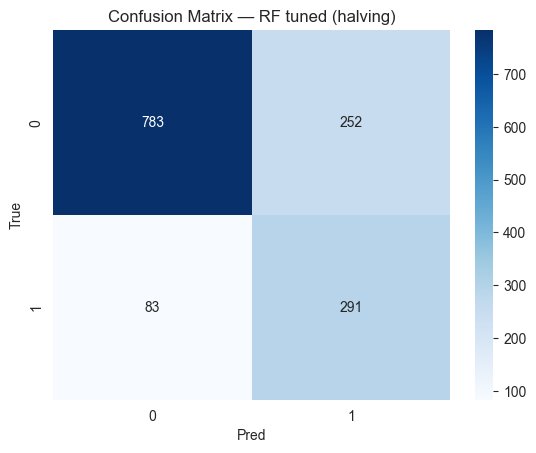

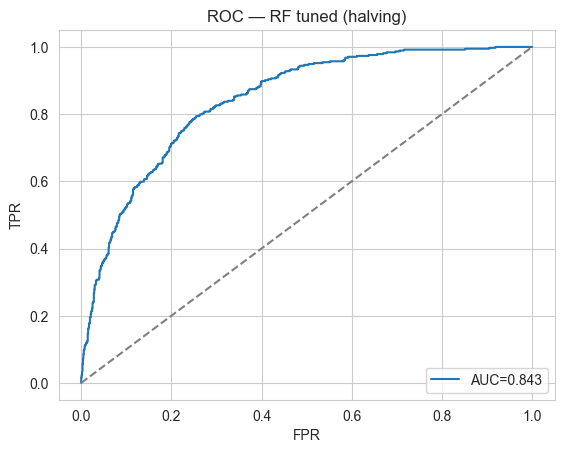

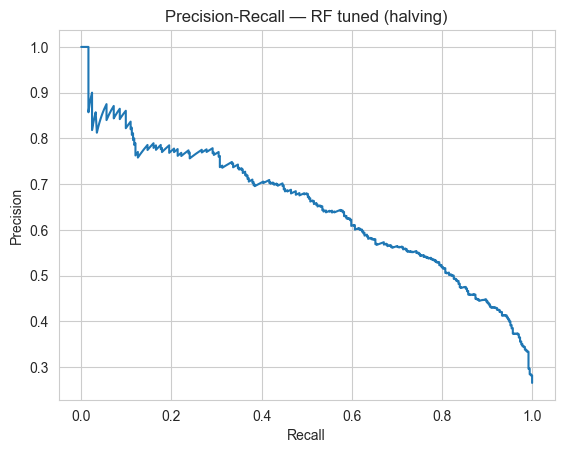

Soglia migliore (max F1): 0.504  |  F1=0.636


In [16]:
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(class_weight='balanced_subsample',
                                   random_state=RNG_SEED, n_jobs=-1))
])

param_dist = {
    'clf__max_depth':         [None, 10, 16, 24],
    'clf__min_samples_split': [2, 5, 10, 20],
    'clf__min_samples_leaf':  [1, 2, 4, 8],
    'clf__max_features':      ['sqrt', 'log2', 0.5],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RNG_SEED)

search = HalvingRandomSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    resource='clf__n_estimators',  # aumenta alberi man mano
    min_resources=100,
    max_resources=800,
    factor=3,                      # scarta i peggiori ad ogni round
    scoring='roc_auc',
    cv=cv,
    random_state=RNG_SEED,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
best_rf = search.best_estimator_
evaluate(best_rf, X_test, y_test, title='RF tuned (halving)')


PUNTO N°10: GESTIONE SBILANCIAMENTO CON SMOTE

[LogReg + SMOTE] Acc=0.737  Prec=0.503  Rec=0.794  F1=0.616  ROC-AUC=0.840
              precision    recall  f1-score   support

           0      0.906     0.717     0.800      1035
           1      0.503     0.794     0.616       374

    accuracy                          0.737      1409
   macro avg      0.705     0.756     0.708      1409
weighted avg      0.799     0.737     0.752      1409



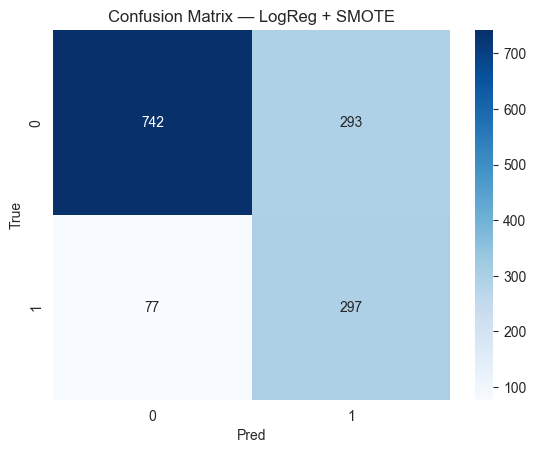

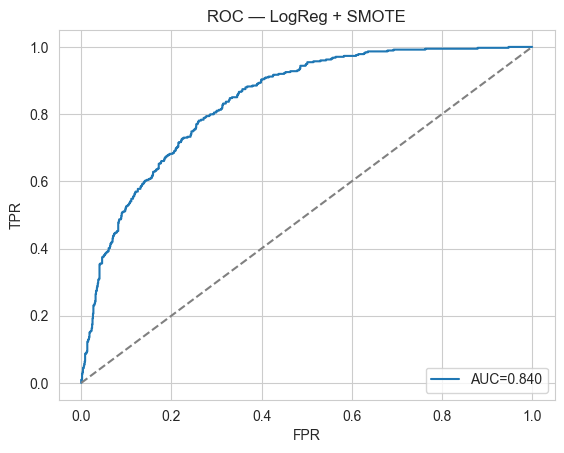

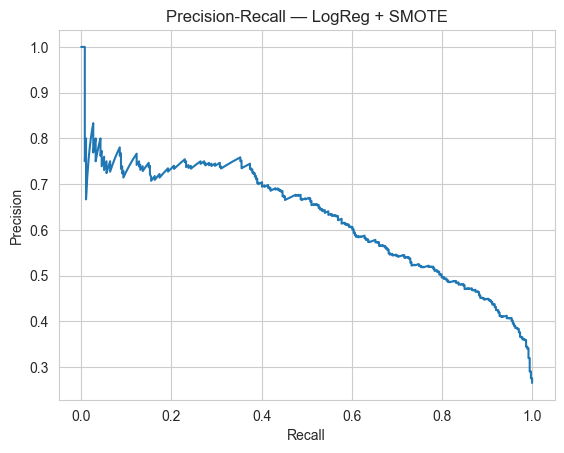

Soglia migliore (max F1): 0.516  |  F1=0.624


In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

# 10.1 Pipeline: PREPROCESS -> SMOTE (solo sul TRAIN) -> Logistic Regression
#      - Togliamo class_weight: SMOTE già riequilibra il train set
smote_logreg = ImbPipeline(steps=[
    ('preprocess', preprocess),                    # imputer + scaler + OHE (fit solo sul train)
    ('smote', SMOTE(random_state=RNG_SEED)),       # crea esempi sintetici della classe minoritaria
    ('clf', LogisticRegression(
        max_iter=500,                              # iterazioni sufficienti per convergenza
        random_state=RNG_SEED                      # riproducibile
    ))
])

# 10.2 Addestramento sul TRAIN e valutazione sul TEST
smote_logreg.fit(X_train, y_train)                 # SMOTE applicato solo al train dentro la pipeline
evaluate(smote_logreg, X_test, y_test,             # metrica completa come al Punto 7
         title='LogReg + SMOTE')

# --- TIP VELOCE ---
# Se vuoi rendere SMOTE ancora più rapido/stabile su dati "stretti":
# smote_logreg.set_params(smote__k_neighbors=3)    # meno vicini per la sintesi (riduce costo/varianza)


PUNTO N°11: TUNING DELLA SOGLIA (MAX F1 E/O RECALL TARGET)

In [18]:
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# 11.1 Scegli quale modello ottimizzare: usa 'best_rf' se esiste, altrimenti 'rf' o 'logreg'
model_to_tune = (
    best_rf if 'best_rf' in globals() else
    rf      if 'rf'      in globals() else
    logreg
)

# 11.2 Probabilità sul TEST (classe positiva "churn = Yes")
proba_test = model_to_tune.predict_proba(X_test)[:, 1]

# 11.3 Funzione che ricava:
#      - soglia che massimizza F1
#      - soglia che garantisce un certo Recall minimo (es. 0.80)
def pick_thresholds(y_true, proba, recall_target=0.80):
    prec, rec, thr = precision_recall_curve(y_true, proba)  # len(thr) = len(prec)-1
    # F1 per ogni soglia (allineo agli indici di 'thr')
    f1s = (2 * prec * rec) / (prec + rec + 1e-12)
    f1s = f1s[:-1]                      # escludo l'ultimo punto (non ha soglia associata)
    thr_f1 = thr[int(np.argmax(f1s))]   # soglia con F1 massimo

    # Soglia per raggiungere almeno 'recall_target'
    mask = rec[:-1] >= recall_target
    thr_rec = thr[mask].max() if np.any(mask) else 0.5
    return float(thr_f1), float(thr_rec)

thr_f1, thr_rec = pick_thresholds(y_test, proba_test, recall_target=0.80)
print(f"Soglia (max F1): {thr_f1:.3f}  |  Soglia (Recall ≥ 0.80): {thr_rec:.3f}")

# 11.4 Valutatore rapido con soglia custom (niente grafici: più veloce)
def eval_at_threshold(y_true, proba, thr, label=""):
    pred = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, pred)
    pre = precision_score(y_true, pred)
    rec = recall_score(y_true, pred)
    f1  = f1_score(y_true, pred)
    roc = roc_auc_score(y_true, proba)
    print(f"[{label}] thr={thr:.3f} | Acc={acc:.3f} Prec={pre:.3f} Rec={rec:.3f} F1={f1:.3f} ROC-AUC={roc:.3f}")
    print(classification_report(y_true, pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_true, pred), "\n")

# 11.5 Report con entrambe le soglie
eval_at_threshold(y_test, proba_test, thr_f1,  label="Max F1")
eval_at_threshold(y_test, proba_test, thr_rec, label="Recall target (0.80)")


Soglia (max F1): 0.504  |  Soglia (Recall ≥ 0.80): 0.467
[Max F1] thr=0.504 | Acc=0.764 Prec=0.539 Rec=0.775 F1=0.636 ROC-AUC=0.843
              precision    recall  f1-score   support

           0      0.904     0.760     0.826      1035
           1      0.539     0.775     0.636       374

    accuracy                          0.764      1409
   macro avg      0.721     0.768     0.731      1409
weighted avg      0.807     0.764     0.775      1409

Confusion matrix:
 [[787 248]
 [ 84 290]] 

[Recall target (0.80)] thr=0.467 | Acc=0.750 Prec=0.519 Rec=0.802 F1=0.630 ROC-AUC=0.843
              precision    recall  f1-score   support

           0      0.911     0.731     0.811      1035
           1      0.519     0.802     0.630       374

    accuracy                          0.750      1409
   macro avg      0.715     0.767     0.721      1409
weighted avg      0.807     0.750     0.763      1409

Confusion matrix:
 [[757 278]
 [ 74 300]] 



PUNTO N°12: INTERPRETABILITA' (RF FEATURE IMPORTANCE, LOGREG COEFFICEINTI, SHAP OPZIONALE)

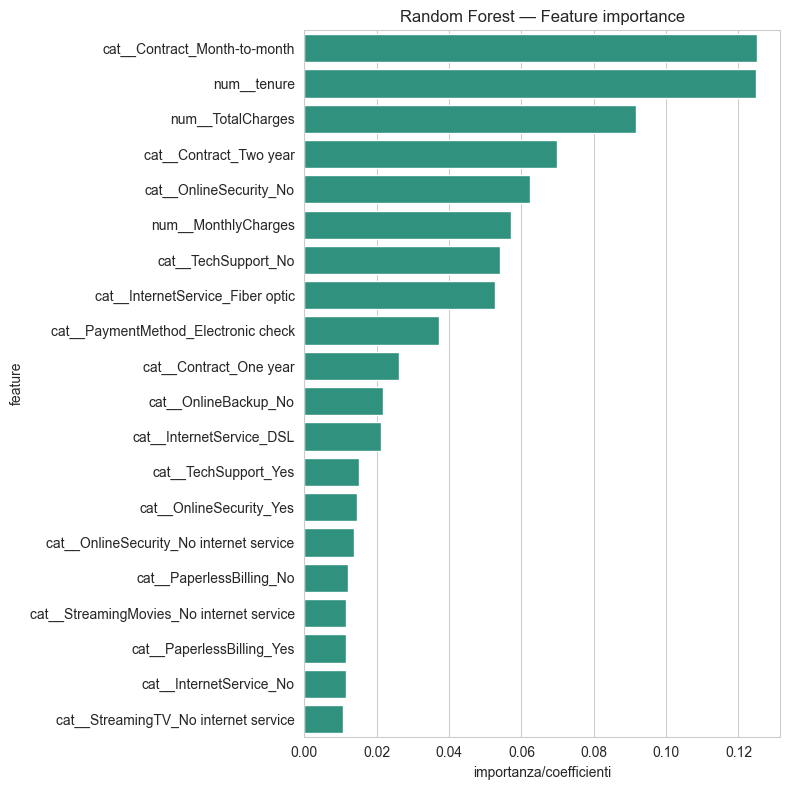

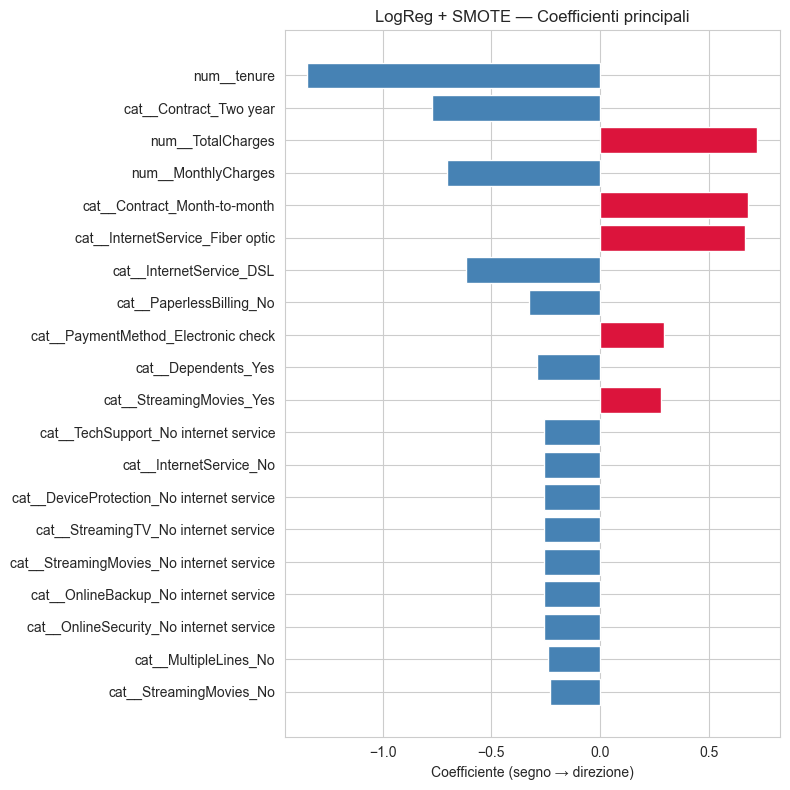

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 12.0 Nomi delle feature dopo il preprocess (servono per tutte le spiegazioni)
feat_names = preprocess.get_feature_names_out()

# 12.1 Utility: barplot orizzontale delle top-k feature
def plot_top(values, names, top=20, title="", cmap='viridis'):
    idx = np.argsort(values)[::-1][:top]                      # indici delle importanze/coef più alti
    dfp = pd.DataFrame({'feature': np.array(names)[idx],
                        'value':   np.array(values)[idx]})
    plt.figure(figsize=(8, 0.35*top + 1))
    sns.barplot(data=dfp, x='value', y='feature', color=sns.color_palette(cmap)[3])
    plt.title(title); plt.xlabel('importanza/coefficienti'); plt.tight_layout(); plt.show()
    return dfp

# 12.2 Random Forest — Feature Importance (veloce)
if 'best_rf' in globals():
    rf_pipe = best_rf
elif 'rf' in globals():
    rf_pipe = rf
else:
    rf_pipe = None

if rf_pipe is not None:
    rf_clf = rf_pipe.named_steps['clf']                       # prende il classificatore dalla pipeline
    imp_df = plot_top(rf_clf.feature_importances_,            # array (n_feature_preprocess,)
                      feat_names, top=20,
                      title='Random Forest — Feature importance')
    # imp_df contiene la tabella ordinata (puoi salvarla o stamparla)

# 12.3 Logistic Regression — coefficienti (segno = direzione dell’effetto)
#      Nota: mostra quanto ogni feature (one-hot inclusa) spinge verso churn (coef>0) o no-churn (coef<0)
def plot_logreg_coefs(pipe, top=20, title=''):
    clf = pipe.named_steps['clf']
    coefs = clf.coef_.ravel()
    dfc = pd.DataFrame({'feature': feat_names,
                        'coef': coefs,
                        'abscoef': np.abs(coefs)}) \
           .sort_values('abscoef', ascending=False).head(top)
    colors = dfc['coef'].apply(lambda v: 'crimson' if v > 0 else 'steelblue')  # rosso=più churn, blu=meno churn
    plt.figure(figsize=(8, 0.35*top + 1))
    plt.barh(dfc['feature'][::-1], dfc['coef'][::-1], color=colors[::-1])
    plt.title(title); plt.xlabel('Coefficiente (segno → direzione)'); plt.tight_layout(); plt.show()
    return dfc

if 'smote_logreg' in globals():
    coefs_df = plot_logreg_coefs(smote_logreg, top=20, title='LogReg + SMOTE — Coefficienti principali')
elif 'logreg' in globals():
    coefs_df = plot_logreg_coefs(logreg,        top=20, title='Logistic Regression — Coefficienti principali')

# 12.4 (OPZIONALE) SHAP per RF — rapido e leggibile
#      Metti RUN_SHAP=True per attivarlo. Usa solo un sottoinsieme per velocità.
RUN_SHAP = False
if RUN_SHAP and rf_pipe is not None:
    try:
        import shap
        # Trasforma X_test con il preprocess per lavorare nello spazio del modello
        Xt = rf_pipe.named_steps['preprocess'].transform(X_test)
        rf_clf = rf_pipe.named_steps['clf']
        explainer = shap.TreeExplainer(rf_clf)               # veloce per modelli ad alberi
        # Usa un campione per grafici rapidi
        idx = np.random.RandomState(42).choice(len(Xt), size=min(200, len(Xt)), replace=False)
        shap_vals = explainer.shap_values(Xt[idx])

        shap.summary_plot(shap_vals[1], Xt[idx], feature_names=feat_names, max_display=20)  # classe 1 = churn
    except Exception as e:
        print("SHAP non eseguito (ok ignorare):", e)


PUNTO N°13: ERROR ANALYSIS

In [22]:
import numpy as np
import pandas as pd

# 13.1 Scegli il modello migliore disponibile + soglia scelta al punto 11
model = (best_rf if 'best_rf' in globals()
         else rf  if 'rf'   in globals()
         else logreg)
thr   = thr_f1 if 'thr_f1' in globals() else 0.50   # fallback 0.5 se non hai scelto una soglia custom

# 13.2 Predizioni sul TEST
proba = model.predict_proba(X_test)[:, 1]
pred  = (proba >= thr).astype(int)

# 13.3 Tabella errori: TP/TN/FP/FN per ogni riga del TEST
errors = X_test.copy()
errors['y_true'] = y_test.values
errors['proba']  = proba
errors['y_pred'] = pred

def _label_err(ytrue, ypred):
    if ytrue == 1 and ypred == 1: return 'TP'
    if ytrue == 0 and ypred == 0: return 'TN'
    if ytrue == 0 and ypred == 1: return 'FP'
    return 'FN'

errors['err'] = np.vectorize(_label_err)(errors['y_true'], errors['y_pred'])

# 13.4 Conteggi complessivi
print("Conteggi TP/TN/FP/FN:", errors['err'].value_counts().to_dict())

# 13.5 DOVE SBAGLIA DI PIÙ SUI CHURNER (False Negative rate per categoria)
#     Per ogni colonna categorica: tra i veri churner (y_true=1), quante volte li predice 0 (FN rate)
def top_fn_by_category(col, min_n=50, top=10):
    g = (errors.query('y_true==1')
               .groupby(col)
               .agg(n=('y_true','size'),
                    fn=('err', lambda s: (s=='FN').sum())))
    g['fn_rate'] = g['fn'] / g['n']
    g = g[g['n'] >= min_n].sort_values('fn_rate', ascending=False).head(top)
    return g

print("\n--- FN rate per categoria (prime 6 categoriche) ---")
for c in cat_features[:6]:  # cambia 6->10 se vuoi più colonne
    try:
        out = top_fn_by_category(c, min_n=40, top=5)
        if not out.empty:
            print(f"\n{c}"); display(out)
    except Exception as e:
        print(f"{c}: skip ({e})")

# 13.6 CARATTERISTICHE NUMERICHE: medie per tipo di errore (utile per pattern veloci)
num_cols = [c for c in num_features if c in errors.columns]
mean_by_err = errors.groupby('err')[num_cols].mean().T
# Ordina mostrando prima le feature con media più alta negli FN
if 'FN' in mean_by_err.columns:
    mean_by_err = mean_by_err.sort_values('FN', ascending=False)
print("\nMedie delle numeriche per tipo di esito (righe=feature):")
display(mean_by_err.head(10))

# 13.7 ESEMPI "critici": casi con alta confidenza ma sbagliati (top 5 FP e FN)
hard_fn = errors.query('err=="FN"').sort_values('proba', ascending=False).head(5)
hard_fp = errors.query('err=="FP"').sort_values('proba', ascending=False).head(5)
print("\nEsempi FN con alta proba (difficili):"); display(hard_fn)
print("\nEsempi FP con alta proba (difficili):"); display(hard_fp)


Conteggi TP/TN/FP/FN: {'TN': 787, 'TP': 290, 'FP': 248, 'FN': 84}

--- FN rate per categoria (prime 6 categoriche) ---

gender


,n,fn,fn_rate
gender,,,
Female,193,47,0.243523
Male,181,37,0.204420



Partner


,n,fn,fn_rate
Partner,,,
Yes,126,46,0.365079
No,248,38,0.153226



Dependents


,n,fn,fn_rate
Dependents,,,
Yes,71,29,0.408451
No,303,55,0.181518



PhoneService


,n,fn,fn_rate
PhoneService,,,
Yes,339,76,0.224189



MultipleLines


,n,fn,fn_rate
MultipleLines,,,
No,177,40,0.225989
Yes,162,36,0.222222



InternetService


,n,fn,fn_rate
InternetService,,,
DSL,97,35,0.360825
Fiber optic,252,33,0.130952



Medie delle numeriche per tipo di esito (righe=feature):


err,FN,FP,TN,TP
TotalCharges,2753.134524,1508.206855,2810.986990,1008.981724
MonthlyCharges,67.759524,73.685685,56.940597,74.217586
tenure,32.928571,17.625000,43.762389,11.693103
SeniorCitizen,0.154762,0.217742,0.088945,0.293103



Esempi FN con alta proba (difficili):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,y_true,proba,y_pred,err
110,Male,0,Yes,No,55,Yes,Yes,Fiber optic,Yes,Yes,...,No,Month-to-month,Yes,Electronic check,96.75,5238.90,1,0.502653,0,FN
469,Female,0,Yes,Yes,13,Yes,No,DSL,No,No,...,Yes,Month-to-month,No,Electronic check,55.95,734.35,1,0.498722,0,FN
4464,Male,0,No,No,12,Yes,No,Fiber optic,Yes,No,...,No,Month-to-month,No,Bank transfer (automatic),81.70,858.60,1,0.497386,0,FN
5207,Female,1,Yes,No,24,No,No phone service,DSL,No,No,...,Yes,Month-to-month,Yes,Credit card (automatic),40.65,933.30,1,0.495896,0,FN
3251,Female,1,No,No,37,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Month-to-month,Yes,Bank transfer (automatic),106.75,4056.75,1,0.493687,0,FN



Esempi FP con alta proba (difficili):


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,y_true,proba,y_pred,err
3346,Female,1,No,No,2,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,84.05,186.05,0,0.921751,1,FP
4039,Male,0,No,No,7,Yes,Yes,Fiber optic,No,No,...,Yes,Month-to-month,Yes,Electronic check,94.10,701.30,0,0.916383,1,FP
2927,Male,0,No,No,1,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,69.90,69.90,0,0.907944,1,FP
2519,Male,0,Yes,No,2,Yes,Yes,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,91.45,171.45,0,0.899383,1,FP
2493,Female,0,Yes,No,6,Yes,Yes,Fiber optic,No,Yes,...,Yes,Month-to-month,Yes,Electronic check,90.75,512.25,0,0.891123,1,FP


PUNTO N°14: SALVATAGGIO DELLA PIPELINE MIGLIORE + METADATI

In [23]:
import os, time, json, joblib, sklearn

# 14.1 Scelgo il modello "migliore" disponibile in memoria (in ordine di priorità)
model = (best_rf        if 'best_rf'        in globals() else   # RF ottimizzata (halving)
         rf_quick       if 'rf_quick'       in globals() else   # RF con buoni default
         rf             if 'rf'             in globals() else   # RF baseline
         smote_logreg   if 'smote_logreg'   in globals() else   # LogReg con SMOTE
         logreg)                                                # LogReg baseline

# 14.2 Cartella artefatti + timestamp per versionare i file
ART_DIR = "artifacts"; os.makedirs(ART_DIR, exist_ok=True)
STAMP   = time.strftime("%Y%m%d-%H%M%S")

MODEL_PATH = f"{ART_DIR}/telco_pipeline_{STAMP}.joblib"   # pipeline completa (preprocess + modello)
META_PATH  = f"{ART_DIR}/telco_meta_{STAMP}.json"         # metadati utili

# 14.3 Salvo la pipeline completa (si ricarica con joblib.load)
joblib.dump(model, MODEL_PATH)

# 14.4 Salvo metadati: soglia scelta, schema input, nomi feature dopo OHE, versioni
thr_used = (thr_f1 if 'thr_f1' in globals()
            else (thr_rec if 'thr_rec' in globals() else 0.50))  # fallback 0.5

meta = {
    "model_path": MODEL_PATH,
    "threshold": float(thr_used),                        # soglia di decisione da usare in produzione
    "features_in": X.columns.tolist(),                  # colonne attese in input (prima del preprocess)
    "features_out": preprocess.get_feature_names_out().tolist(),  # nomi dopo OHE/scaler
    "model_type": type(model.named_steps['clf']).__name__,
    "sklearn_version": sklearn.__version__,
    "created_at": STAMP
}

with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=2)

print("SALVATO:")
print(" - Pipeline:", MODEL_PATH)
print(" - Metadati:", META_PATH)


SALVATO:
 - Pipeline: artifacts/telco_pipeline_20250904-170056.joblib
 - Metadati: artifacts/telco_meta_20250904-170056.json
